In [97]:
from math import sqrt, pi, log, exp
import sys
if "spnhelp" in sys.modules.keys():
    del sys.modules["spnhelp"]
import spnhelp
import matplotlib.pyplot as plt
import scipy.stats as stats
from spn.algorithms.Inference import likelihood
import numpy as np

def integrate_log_normal(a : float, b : float, w : float) -> float: # standard normal
    t1 = a ** 2
    t3 = b ** 2
    p = 0.25 #!
    t5 = log(1 - p)
    t10 = log(-w / (a - b))
    t12 = log(pi)
    t14 = log(2)
    return (b * a + t1 + 6 * t10 + 3 * t12 + 3 * t14 + t3 + 6 * t5) * w / 6


def integrate_log_normal_slope(a : float , b : float, w : float, s : float): # standard normal
    t1 = a - b
    t2 = t1 ** 2
    t3 = t2 * s
    t4 = 2 + t3
    t5 = t4 ** 2
    t7 = 0.1e1 / t1
    t9 = log(-t7 * w * t4)
    t12 = -2 + t3
    t13 = t12 ** 2
    t16 = log(t7 * w * t12)
    t23 = a ** 2
    t25 = exp(-t23 / 2)
    p = 0.25 #!
    t27 = 1 / (-1 + p)
    t29 = log(-t27 * t25)
    t36 = b ** 2
    t38 = exp(-t36 / 2)
    t40 = log(-t27 * t38)
    t43 = log(pi)
    t45 = log(2)
    t47 = t23 ** 2
    t54 = t36 ** 2
    return -0.1e1 / t2 / s * w * (-3 * t9 * t5 + 3 * t16 * t13 + t1 * s * (12 * t29 * (t1 * s * b + 2) * a - 12 * t40 * (t1 * s * a + 2) * b + t1 * (-12 * t43 + 12 * t45 + s * (4 * b * t23 * a - 4 * t36 * b * a + t47 - t54) + 8 * t23 + 8 * b * a + 8 * t36 + 12))) / 24



In [98]:
def kl_uni (s, e, w):
    kl = 0
    for i in range(len(s)):
        kl += integrate_log_normal(s[i], e[i], w[i])
    return np.array(kl)


def kl_slopy (s, e, w, slope):
    kl = 0
    for i in range(len(s)):
        if w[i] > 0:
            max_abs_of_slope = 1/(0.5*(e[i]-s[i])**2)
            clamped_slope = min(max(slope[i], -max_abs_of_slope), max_abs_of_slope)
            kl += integrate_log_normal_slope(s[i], e[i], w[i], clamped_slope)
    return np.array(kl)

In [99]:
splits = []
splits.append((zip(*spnhelp.gauss_discretization_params(0, 1, 1.05, spnhelp.CRIT_uniform_bounded_ratio)), "bounded deviation"))
splits.append((zip(*spnhelp.gauss_discretization_params(0, 1, 0.05, spnhelp.CRIT_uniform_bounded_deviation)), "bounded ratio"))
splits.append((zip(*spnhelp.gauss_discretization_params(0, 1, 10, spnhelp.CRIT_even_partition)), "even partition"))

for (starts, _, ends, weights, slopes), name in splits:
    kl_ =  kl_uni(starts, ends, weights)
    kl__ = kl_slopy(starts, ends, weights, slopes)
    n = len(starts)
    print("kl      :", f"{(kl_):.5f}", n, "with components for", name)
    print("kl_slope:", f"{(kl__):.5f}", n, "with components for ", name)

kl      : -0.28650 164 with components for bounded deviation
kl_slope: -0.28668 164 with components for  bounded deviation


ValueError: math domain error

Text(0.5, 0, 'eps')

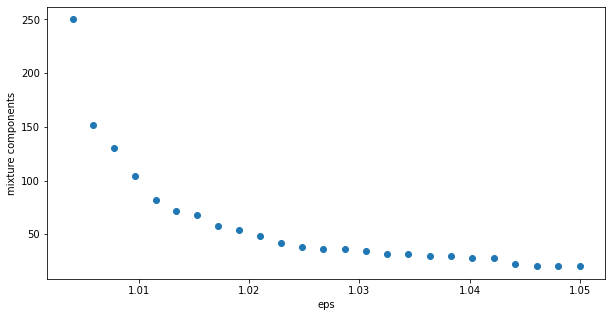

In [ ]:
xs = np.exp(np.linspace(np.log(1.004), np.log(1.05), 25))
plt.scatter(xs, [len(spnhelp.gauss_discretization_params(0, 1, e, spnhelp.CRIT_uniform_bounded_ratio)) for e in xs])
plt.ylabel("mixture components")
plt.xlabel("eps")

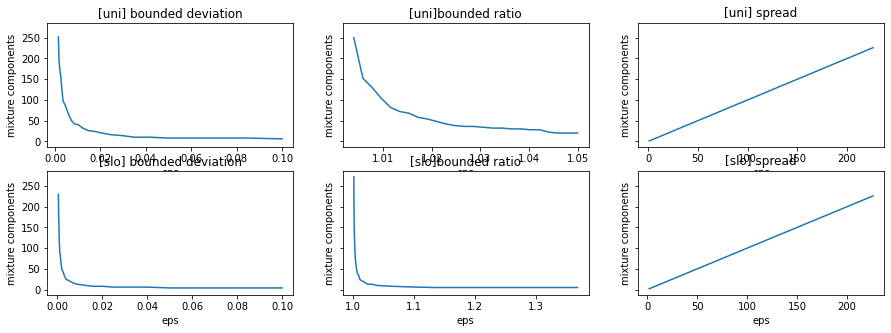

In [ ]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(15,5))

names = ["[uni] bounded deviation", "[uni]bounded ratio", "[uni] spread", "[slo] bounded deviation", "[slo]bounded ratio", "[slo] spread"]
splits = []
splits.append((False, lambda e: spnhelp.gauss_discretization_params(0, 1, e, spnhelp.CRIT_uniform_bounded_deviation), np.exp(np.linspace(np.log(0.0015), np.log(0.1), 25))))
splits.append((False, lambda e: spnhelp.gauss_discretization_params(0, 1, e, spnhelp.CRIT_uniform_bounded_ratio), np.exp(np.linspace(np.log(1.004), np.log(1.05), 25))))
splits.append((False, lambda e: spnhelp.gauss_discretization_params(0, 1, e, spnhelp.CRIT_even_partition), range(1, 250, 25)))

splits.append((True, lambda e: spnhelp.gauss_discretization_params(0, 1, e, spnhelp.CRIT_slopyform_bounded_deviation), np.logspace(-3.4, -1, 25)))
splits.append((True, lambda e: spnhelp.gauss_discretization_params(0, 1, e, spnhelp.CRIT_slopyform_bounded_ratio), 1 + np.exp(np.linspace(-7, -1, 25))))
splits.append((True, lambda e: spnhelp.gauss_discretization_params(0, 1, e, spnhelp.CRIT_even_partition), [2, 26, 52, 76, 102, 126, 152, 176, 202, 226]))

test_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
kls = [[] for s in splits]

for i, (is_sloped, f, xs) in enumerate(splits):
    name = names[i]
    
    params = np.array([f(e) for e in xs], dtype=object)
    n_components = np.array([len(p) for p in params])

    for t in test_components:
        # x = xs[np.argmin(np.abs(n_components - t))]
        starts, _, ends, weights, slopes = zip(*params[np.argmin(np.abs(n_components - t))])
        
        if not is_sloped:
            kl_ = kl_uni(starts, ends, weights)
        else:
            kl_ = kl_slopy(starts, ends, weights, slopes)
        
        n = len(starts)
        kls[i].append((kl_, n))
        
    ax[1 if is_sloped else 0, i%3].plot(xs, n_components)
    ax[1 if is_sloped else 0, i%3].set_ylabel("mixture components")
    ax[1 if is_sloped else 0, i%3].set_xlabel("eps")
    ax[1 if is_sloped else 0, i%3].set_title(name)

In [ ]:
print(kls[0])

[(array(0.00061774), 2), (array(2.98080311e-08), 26), (array(2.98080311e-08), 26), (array(1.8639299e-09), 52), (array(1.8639299e-09), 52), (array(1.8639299e-09), 52), (array(4.08542092e-10), 76), (array(4.08542092e-10), 76), (array(1.25922102e-10), 102), (array(1.25922102e-10), 102), (array(1.25922102e-10), 102), (array(5.40941541e-11), 126), (array(5.40941541e-11), 126), (array(2.55435651e-11), 152), (array(2.55435651e-11), 152), (array(2.55435651e-11), 152), (array(1.41983126e-11), 176), (array(1.41983126e-11), 176), (array(8.17739912e-12), 202), (array(8.17739912e-12), 202), (array(8.17739912e-12), 202), (array(5.24990932e-12), 226), (array(5.24990932e-12), 226), (array(5.24990932e-12), 226), (array(5.24990932e-12), 226)]


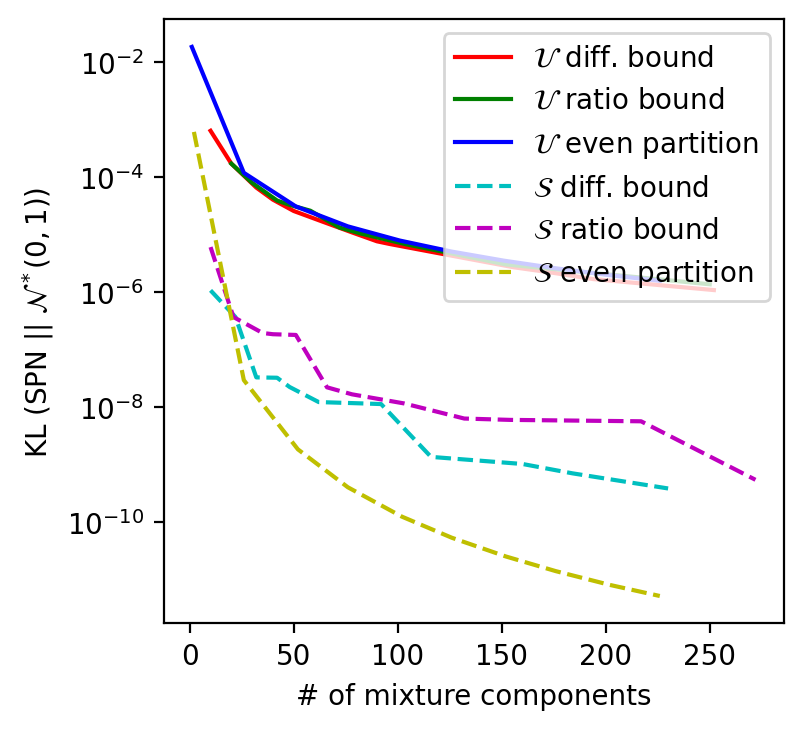

In [103]:
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 200
names = ["$\mathcal{U}$ diff. bound", "$\mathcal{U}$ ratio bound", "$\mathcal{U}$ even partition", "$\mathcal{S}$ diff. bound", "$\mathcal{S}$ ratio bound", "$\mathcal{S}$ even partition"]

colors = ["r", "g", "b", "c", "m", "y"]
styles = ["-"] * 3 + ["--"] * 3
for run, name, color, style in zip(kls, names, colors, styles):
    kl_, n = zip(*run)
    plt.plot(n, kl_, label = name, c=color, ls=style)

plt.xlabel("# of mixture components")
plt.ylabel("KL (SPN || $\mathcal{N}^*(0,1)$)")
plt.yscale("log")
# plt.title("KL Divergence between SPN and Truncated Gaussian for different\n partitioning schemes and amounts of mixture components")
plt.legend(loc = "upper right")